In [ ]:
import os
import sys
sys.path.append(os.path.abspath("/ocean/projects/asc170022p/shg121/PhD/Project_Pruning"))
import h5py
import pickle
from sklearn.utils import shuffle
import numpy as np
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import time
import pickle

import torch
from torch.utils.data import DataLoader
from torchvision import transforms

import utils
from model_factory.models import Classifier
from model_factory.model_meta import Model_Meta
from dataset.dataset_utils import get_dataset_with_attributes, get_transforms
from dataset.dataset_attributes_mnist import Dataset_attributes_mnist

import matplotlib.pyplot as plt

In [2]:
seed = 0
device = utils.get_device()
print(f"Device: {device}")
data_root = "/ocean/projects/asc170022p/shg121/PhD/Project_Pruning/data/MNIST_EVEN_ODD"
json_root = "/ocean/projects/asc170022p/shg121/PhD/Project_Pruning/scripts_data"
model_arch = "Resnet_18"
dataset_name = "mnist"
pretrained = True
transfer_learning = False
chk_pt_path = "seq_epoch_20.pth.tar"
num_classes = 1
logs = "/ocean/projects/asc170022p/shg121/PhD/Project_Pruning/output"
bb_layer = "layer3"  # layer3
concept_names = ["Zero", "One", "Two", "Three", "Four", "Five", "Six", "Seven", "Eight", "Nine"]
img_size = 224
batch_size = 3
epochs = 50
num_workers = 4
class_list = [0, 1]
num_labels = len(class_list)
cav_vector_file = "max_pooled_train_cavs.pkl"
kernel_size={
    "layer3": 14,
    "layer4": 7
}

prune_type = "lt"
lr = 1e-3
ITERATION  = 35
prune_percent = 10
start_iter = 0
end_iter = 100
resample = False
reinit = True if prune_type=="reinit" else False


Device: cuda


In [14]:
prune_stats_file_name = "prune_stats_for_prune_typelt.pkl"
checkpoint_path = os.path.join(logs, "chk_pt", "Pruning", model_arch, dataset_name)
prune_stat_path = os.path.join(checkpoint_path, "prune-statistics", "train")

percent_weight_remaining = np.array([100.,   90.,   81.,   72.9,  65.6,  59.1,  53.2,  47.8,  43.1,  38.8,  34.9,  31.4,
  28.3,  25.4,  22.9,  20.6,  18.6,  16.7,  15.,   13.5,  12.2,  11.,    9.9,   8.9,
   8.,    7.2,   6.5,   5.9,   5.3,   4.7,   4.3,   3.9,   3.5,   3.1,   2.8,])

In [13]:
prune_stats_file = open(
        os.path.join(prune_stat_path, prune_stats_file_name),
        "rb")
prune_stats = pickle.load(prune_stats_file)
print(len(prune_stats))
print(prune_stats[0])

35
{'all_train_loss': array([0.00168175, 0.0006753 , 0.00050492, 0.0004642 , 0.00037938,
       0.00033487, 0.00032308, 0.00033529, 0.00033575, 0.00035247,
       0.00034816, 0.00038782]), 'all_train_accuracy': array([91.33958333, 96.91458333, 97.90416667, 97.98333333, 98.35833333,
       98.57916667, 98.62708333, 98.58541667, 98.54166667, 98.46458333,
       98.50208333, 98.27083333]), 'all_val_loss': array([0.00541195, 0.00596312, 0.00088908, 0.00107649, 0.00071308,
       0.00074791, 0.0019027 , 0.00108342, 0.06865017, 0.00054356,
       0.00132928, 0.00035904]), 'all_val_accuracy': array([50.85      , 52.30833333, 96.325     , 95.95      , 97.49166667,
       96.88333333, 91.50833333, 95.55      , 49.74166667, 98.48333333,
       95.15      , 98.46666667]), 'best_accuracy': 98.48333333333333}


In [17]:
best_acc_arr = []
for stats in prune_stats:
    best_acc_arr.append(stats['best_accuracy'])


np_best_acc_arr = np.array(best_acc_arr)

np_best_acc_arr

array([98.48333333, 96.90833333, 97.09166667, 95.5       , 98.20833333,
       98.43333333, 97.30833333, 97.63333333, 97.54166667, 87.85      ,
       96.34166667, 96.44166667, 93.        , 96.03333333, 95.60833333,
       94.9       , 91.725     , 96.05833333, 94.075     , 92.725     ,
       84.23333333, 93.90833333, 87.44166667, 68.08333333, 82.375     ,
       72.23333333, 86.40833333, 74.5       , 78.20833333, 63.21666667,
       52.65833333, 51.55      , 58.6       , 50.85      , 50.85      ])

In [42]:
plot_path = os.path.join(logs, "chk_pt", "Pruning", model_arch, dataset_name, "plots")
utils.create_dir({
    "path_name": plot_path,
    "path_type": "plots-path"
})

plots-path directory is created successfully at:
/ocean/projects/asc170022p/shg121/PhD/Project_Pruning/output/chk_pt/Pruning/Resnet_18/mnist/plots


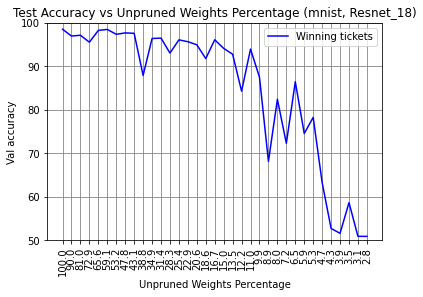

In [45]:
a = np.arange(len(best_acc_arr))
plt.plot(a, np_best_acc_arr, c="blue", label="Winning tickets") 
plt.title(f"Test Accuracy vs Unpruned Weights Percentage ({dataset_name}, {model_arch})") 
plt.xlabel("Unpruned Weights Percentage") 
plt.ylabel("Val accuracy") 
plt.xticks(a, percent_weight_remaining, rotation ="vertical") 

plt.ylim(50, 100)
plt.legend() 
plt.grid(color="gray") 
plt.savefig(f"{plot_path}/{prune_type}_val_Accuracy_Vs_Weights.png", dpi=1200) 
plt.show()
plt.close()